<a href="https://colab.research.google.com/github/Akash-D-wivedi/phase-transformation-jmak/blob/main/notebooks/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Phase‐Transformation Kinetics: JMAK Analysis**

This notebook demonstrates:
1. Loading TTT data
2. Fitting the JMAK equation (Avrami exponent & rate constants)
3. Arrhenius analysis (k₀, Q)
4. Gaussian‐Process smoothing
5. Synthetic curve generation
6. Visualization and uncertainty quantification

In [8]:
# Clone your repo once per session
!git clone https://github.com/Akash-D-wivedi/phase-transformation-jmak.git
%cd phase-transformation-jmak

# Install any missing dependencies
!pip install --quiet numpy pandas scipy scikit-learn matplotlib openpyxl chardet

Cloning into 'phase-transformation-jmak'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 52 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 201.55 KiB | 2.62 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/phase-transformation-jmak/phase-transformation-jmak


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from pathlib import Path
import warnings

# Points per synthetic curve, GP length‐scale, gas constant
LOGPOINTS = 50
GP_LSCALE = 100.0
R_CONST   = 8.314  # J/(mol·K)

# Paths (relative now that we're inside the cloned repo)
DATA_DIR  = Path("data")
CSV_FILE  = DATA_DIR / "TTT data_Steel.csv"
OUT_XLSX  = DATA_DIR / "TTT-synthetic.xlsx"

# **Load & Clean Data**
---
We auto-detect encoding, normalize column names, and preview the first few rows.


In [13]:
# If encoding errors, uncomment and adjust encoding="ISO-8859-9"
df_raw = pd.read_csv(CSV_FILE)
df_raw.head()

,Phase,T (°C),t_start,t_10%,t_90%,y_max
0,Ferrite,470.0,2.1,4.3,9.4,0.4
1,Ferrite,480.0,1.9,3.7,7.9,0.4
2,Ferrite,490.0,1.7,3.2,6.7,0.4
3,Ferrite,500.0,1.5,2.8,5.7,0.4
4,Ferrite,510.0,1.4,2.6,5.0,0.4


# **Cleaning Data**


---



Melt the 0%, 10%, and 90% times into a long format for fitting.

In [19]:
# clean up column names
df_raw.columns = (
    df_raw.columns
          .str.strip()
          .str.lower()
          .str.replace(" ", "_")
          .str.replace(r"[^0-9a-z_]", "", regex=True)
)

# melt 0%, 10%, 90% times into long form
tidy = (
    df_raw.melt(
        id_vars=["phase","t_c","y_max"],
        value_vars=["t_start","t_10","t_90"],
        var_name="time_kind", value_name="time_s"
    )
    .assign(fraction=lambda d: d.time_kind.map({
        "t_start":0.0, "t_10":0.10, "t_90":0.90
    }))
    .dropna(subset=["time_s"])
)
tidy.head()

,phase,t_c,y_max,time_kind,time_s,fraction
0,Ferrite,470.0,0.4,t_start,2.1,0.0
1,Ferrite,480.0,0.4,t_start,1.9,0.0
2,Ferrite,490.0,0.4,t_start,1.7,0.0
3,Ferrite,500.0,0.4,t_start,1.5,0.0
4,Ferrite,510.0,0.4,t_start,1.4,0.0


# **Fit JMAK Parameters (n & k(T))**


---



**Goal:** For each phase (ferrite, pearlite, bainite), find the best Avrami exponent n and the per‐temperature rate constants k(T) that make the JMAK model

$$
f(t) \;=\; y_{\max}\bigl[1-e^{-(k\,t)^n}\bigr]
$$

pass through your three anchor points at 0 %, 10 %, and 90 % transformed.

**How it works:**

1. **Group by phase** and extract the unique temperatures T.
2. **Pack parameters** into a single vector $n,\ln k(T_1),…,\ln k(T_M)$.
3. **Initial guess:**

   * $n=2$
   * $k(T)\approx 1/\langle t_{10\!-\!90}\rangle$
4. **Residual function:** For each data point $(T_i, t_s, y_{\max}, \text{frac})$, compute

   $$
     \hat f = y_{\max}\bigl[1 - e^{-(k(T_i)\,t_s)^n}\bigr]
   $$

   and return $\hat f - (\text{frac}\cdot y_{\max})$.
5. **Least-squares solve** (`least_squares`) adjusts n and all $k(T_i)$ to drive those residuals to zero.
6. **Unpack** the solution and store $\{n,\;k_T\}$ in `results`.

In [20]:
results = {}
for phase, grp in tidy.groupby("phase"):
    Ts = np.sort(grp["t_c"].unique())

    # helpers to pack/unpack parameters
    def pack(n, logk):        return np.r_[n, logk]
    def unpack(p):
        n_fit = p[0]
        kdict = dict(zip(Ts, np.exp(p[1:])))
        return n_fit, kdict

    # initial guess: n=2, k≈1/mean(time)
    invt = 1.0/ grp.groupby("t_c")["time_s"].mean().reindex(Ts).values
    p0   = pack(2.0, np.log(np.clip(invt,1e-12,None)))

    def residuals(p):
        n_fit, kdict = unpack(p)
        pred = grp.apply(
            lambda r: r.y_max*(1 - np.exp(-(kdict[r.t_c]*r.time_s)**n_fit)),
            axis=1
        )
        return pred.values - (grp.fraction*grp.y_max).values

    sol = least_squares(residuals, p0, max_nfev=20000)
    n_fit, kdict = unpack(sol.x)
    results[phase] = {"n":n_fit, "k_T":kdict}
    print(f"{phase:10s} n={n_fit:.2f}  k-range={min(kdict.values()):.2e}–{max(kdict.values()):.2e}")


Bainite    n=6.95  k-range=3.73e-07–1.39e-01
Ferrite    n=3.76  k-range=5.74e-05–1.31e+47
Perlite    n=3.72  k-range=3.79e-07–7.82e-02


# **Arrhenius Fit (k₀ and Q)**


---


Condense your discrete rate constants $k(T)$ into the classic Arrhenius law

$$
k(T) = k_0\,\exp\!\bigl(-Q/(R\,T_{\rm K})\bigr),
$$

to extract a single activation energy $Q$ and pre-exponential factor $k_0$ for each phase.

**How it works:**

1. For each phase, pull out the arrays
   $\{T_i\}$ (in °C) and $\{k_i\}$.
2. Define the Arrhenius function in terms of Kelvin:
   $\mathrm{arrh}(T_{\rm C},k_0,Q)=k_0\exp[-Q/(R(T_{\rm C}+273.15))]$.
3. Call `curve_fit` to find the best $(k_0,Q)$ that minimize $\sum_i [k_i - \mathrm{arrh}(T_i)]^2$.
4. Store and tabulate those $k_0$ and $Q$ (converted to kJ/mol).

This gives us a neat two-parameter description of how the rate constant varies with temperature.


In [21]:
arr_params = {}
for phase, info in results.items():
    Tvals = np.array(list(info["k_T"].keys()))
    kvals = np.array(list(info["k_T"].values()))

    def arrh(T, k0, Q):
        return k0 * np.exp(-Q/(R_CONST*(T+273.15)))

    popt, _ = curve_fit(arrh, Tvals, kvals, p0=[1e5,8e4], bounds=(0,[np.inf,np.inf]))
    arr_params[phase] = {"k0":popt[0], "Q":popt[1]}

pd.DataFrame([
    {"phase":ph, "k0 (1/s)":v["k0"], "Q (kJ/mol)":v["Q"]/1000}
    for ph,v in arr_params.items()
]).T

,0,1,2
phase,Bainite,Ferrite,Perlite
k0 (1/s),3.573296,100000.0,0.041411
Q (kJ/mol),24.051349,80.0,0.0


# **GP Smoothing & Synthetic Curve Generation**



---



1. Use a Gaussian Process to smoothly interpolate $\ln k$ vs T (so you can predict $k$ at any temperature, not just your experimental points).
2. Generate “synthetic” JMAK curves $f(t)$ on a log-spaced time axis for each original isotherm.

**How it works:**

1. **Build `ymax` lookup** from your raw table so you know the asymptotic fraction for each (phase, T).
2. **For each phase:**

   * Train a GP on

     $$
       x = T_i,\quad y = \ln k(T_i).
     $$
   * This GP learns a smooth function $\mu(T)\pm\sigma(T)$.
3. **For each isothermal T:**

   * Compute a log-spaced time grid from just before start time (e.g. where $f\approx0.01$) up to a few times beyond your longest experimental time.
   * Use your fitted $n$ and the original $k(T)$ (not the GP) to make

     $$
       f(t) = y_{\max}\bigl[1-\exp(-(k\,t)^n)\bigr]
     $$

     at each grid point.
   * Append those $(phase,T,t,f)$ rows into `syn_df`.

We have a smooth, high-resolution dataset of “synthetic” transformation curves for every isotherm.

In [22]:
# y_max lookup
ymax = {(r.phase,r.t_c):r.y_max for r in df_raw.itertuples()}

rows = []
for phase, info in results.items():
    n_fit = info["n"]
    kdict = info["k_T"]
    # train GP on ln(k) vs T
    T_arr = np.array(list(kdict)).reshape(-1,1)
    logk  = np.log(list(kdict.values()))
    gp    = GaussianProcessRegressor(C(1.0)*RBF(GP_LSCALE), alpha=0.05, normalize_y=True)
    gp.fit(T_arr, logk)

    for T,k in kdict.items():
        ym = ymax[(phase,T)]
        tmin = max(1e-3,(0.01/k)**(1/n_fit))
        tmax = tidy.query("phase==@phase and t_c==@T").time_s.max()*5
        tgrid= np.logspace(np.log10(tmin), np.log10(tmax), LOGPOINTS)
        frac = ym*(1 - np.exp(-(k*tgrid)**n_fit))
        for t,f in zip(tgrid,frac):
            rows.append({"phase":phase,"T_C":T,"time_s":t,"fraction":f})

syn_df = pd.DataFrame(rows)
syn_df.head()

,phase,T_C,time_s,fraction
0,Bainite,10.0,4.333126,0.0
1,Bainite,10.0,5.891912,0.0
2,Bainite,10.0,8.011450,0.0
3,Bainite,10.0,10.893465,0.0
4,Bainite,10.0,14.812246,0.0


# **Plot + 95 % Confidence Bands**



---


Visually check how well your model fits the data and quantify uncertainty in $k(T)$ via the GP’s standard deviation.


1. **Retrain** the GP on $\ln k$ vs T (this time so you can query its uncertainty).
2. For three representative temperatures (coldest, mid, hottest):

   * **Scatter** the original 0/10/90 % anchor points.
   * **Plot** the synthetic JMAK curve.
   * **Compute CI:**

     * Get $\mu\pm1.96\,\sigma$ in log-k space at that T → exponentiate → two rates $k_{\rm lo}, k_{\rm hi}$.
     * Generate two JMAK curves with $k_{\rm lo}$ and $k_{\rm hi}$.
     * Fill between them in gray.
3. **Format:** Log-scale the x-axis, label everything, and show a legend.

This cell gives us side-by-side plots showing raw data, best‐fit curve, and uncertainty band—crucial for trusting your predictions.



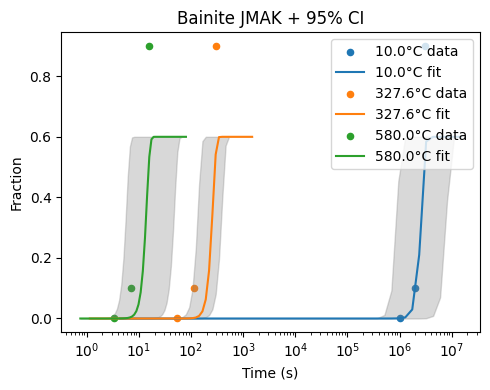

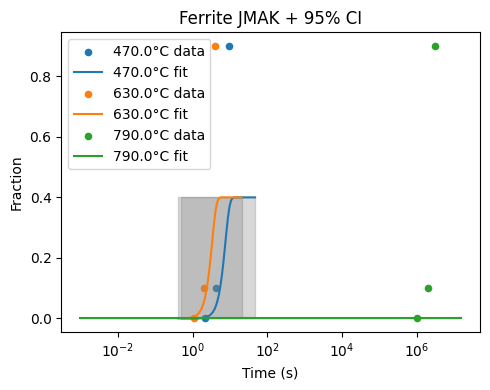

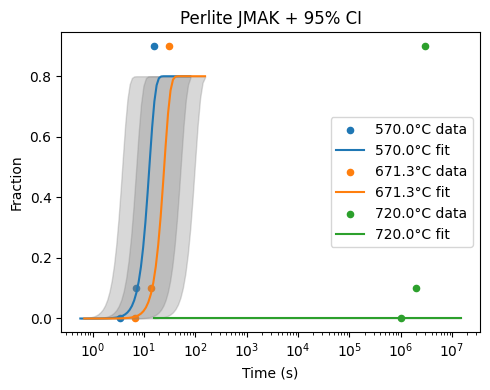

In [24]:
for phase, info in results.items():
    n_fit = info["n"]
    kdict = info["k_T"]
    # retrain GP for CI
    Tarr = np.array(list(kdict)).reshape(-1,1)
    logk = np.log(list(kdict.values()))
    gp   = GaussianProcessRegressor(C(1.0)*RBF(GP_LSCALE), alpha=0.05, normalize_y=True).fit(Tarr,logk)

    fig, ax = plt.subplots(figsize=(5,4))
    df_o = tidy[tidy.phase==phase]
    df_s = syn_df[syn_df.phase==phase]
    Ts   = sorted(df_o["t_c"].unique())
    picks=[Ts[0],Ts[len(Ts)//2],Ts[-1]]
    for T in picks:
        pts = df_o[df_o.t_c==T]
        curve = df_s[df_s.T_C==T]
        ax.scatter(pts.time_s, pts.fraction, s=20, label=f"{T}°C data")
        ax.plot(curve.time_s, curve.fraction, label=f"{T}°C fit")
        ym = ymax[(phase,T)]
        mu,sig = gp.predict([[T]],return_std=True)
        kh = np.exp(mu+1.96*sig)[0]; kl=np.exp(mu-1.96*sig)[0]
        f_hi = ym*(1-np.exp(-(kh*curve.time_s)**n_fit))
        f_lo = ym*(1-np.exp(-(kl*curve.time_s)**n_fit))
        ax.fill_between(curve.time_s, f_lo, f_hi, color="gray", alpha=0.3)
    ax.set_xscale("log")
    ax.set_xlabel("Time (s)"); ax.set_ylabel("Fraction")
    ax.set_title(f"{phase.capitalize()} JMAK + 95% CI")
    ax.legend()
    plt.tight_layout(); plt.show()